In [1]:
import numpy as np
import matplotlib.pyplot as plt

import spikeinterface.extractors as se
import spikeinterface.sorters as ss
# import spikeinterface.comparison as sc
import spikeinterface.exporters as sxp
import spikeinterface.widgets as sw
import spikeinterface.full as si
import probeinterface as pi
# import spikeinterface_gui

import os
import time
from pathlib import Path

C:\Users\lwood39\.conda\envs\spikesort\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [20]:
## If reading series of intan recordings
# rec_name = '230419_Msexta.male016/rec01'
rec_name = '20220431_poke3_230421_155633'
# path_to_folder = Path('G:/SponbergLab/Data/'+rec_name)
# path_to_folder = Path('F:/VNCMP/2022_11_16/intan/moth0_1_221116_154712')
path_to_folder = Path('C:/Users/lwood39/Documents/VNCMP/20230421/' + rec_name)
dircontents = os.listdir(path_to_folder)
file_names = [x for x in dircontents if '.rhd' in x]
recording_list = []
for file in file_names:
    path_to_file = os.path.join(path_to_folder, file)
    recording_list.append(se.IntanRecordingExtractor(path_to_file, stream_id='0'))
recording = si.concatenate_recordings(recording_list)
display(recording)


## If reading open ephys recording session
# path_to_folder = Path('G:/SponbergLab/Data/Leo_2023-03-29_15-03-40/Record Node 103/experiment1')
# # path_to_folder = Path('G:/VNCMP/20230308/2023-03-08_13-08-30/Record Node 104')
# recording = se.read_openephys(path_to_folder, block_index=0, stream_id='0')
# recording = si.SelectSegmentRecording(recording, 0)

ConcatenateSegmentRecording: 32 channels - 1 segments - 30.0kHz - 736.930s

In [21]:
# Remove analog input channels if present, not needed for spike sorting
if any('ADC' in s for s in recording.get_channel_ids()):  
    recording = recording.remove_channels([x for x in recording.get_channel_ids() if 'ADC' in x])
recording.get_channel_ids()

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31'], dtype='<U64')

Probe - 32ch - 1shanks

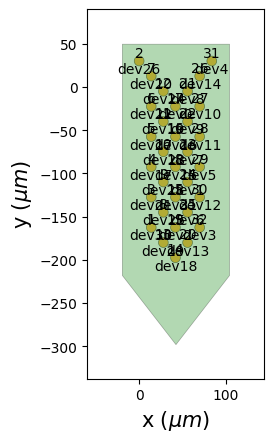

In [22]:
probe = pi.read_probeinterface('A32_A1x32-Poly5-6mm-35s-100.json')
# probe = pi.read_probeinterface('CM32_A1x32-Poly5-6mm-35s-100.json')
pi.plotting.plot_probe_group(probe, with_channel_index=True, with_device_index=True)
# recording.set_probegroup(probe)
recording.set_probe(probe.probes[0], in_place=True)
recording.get_probe()

In [23]:
recording_f = si.bandpass_filter(recording, freq_min=300, freq_max=7500)
recording_cmr = si.common_reference(recording_f, reference='global', operator='median')
recording_cache_preprocessed = recording_cmr.save(format='binary', n_jobs=8, chunk_duration='10s')
recording_cache_raw = recording.save(format='binary', n_jobs=8, chunk_duration='10s')

Use cache_folder=C:\Users\lwood39\AppData\Local\Temp\spikeinterface_cache\tmpcdouoxay\COH4AL4H
write_binary_recording with n_jobs = 8 and chunk_size = 300000
Use cache_folder=C:\Users\lwood39\AppData\Local\Temp\spikeinterface_cache\tmpbsh9x6vs\IDQ2DQ0Y
write_binary_recording with n_jobs = 8 and chunk_size = 300000


slice(None, None, None)


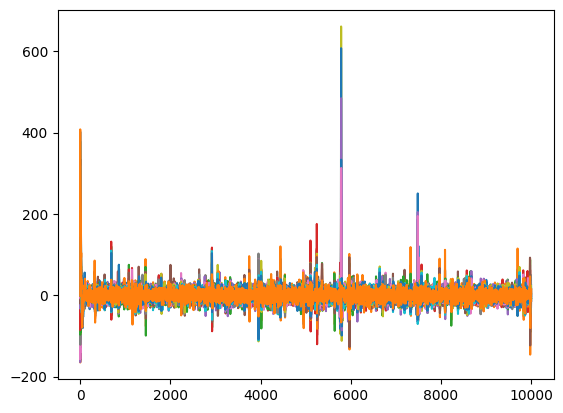

In [25]:
# sw.plot_timeseries(recording, time_range=(0,50), channel_ids=['0'])
plt.plot(recording_cmr.get_traces(start_frame=0, end_frame=10000*1, return_scaled=True))
plt.show()

In [26]:
si.available_sorters()

['combinato',
 'hdsort',
 'herdingspikes',
 'ironclust',
 'kilosort',
 'kilosort2',
 'kilosort2_5',
 'kilosort3',
 'klusta',
 'mountainsort4',
 'pykilosort',
 'spykingcircus',
 'spykingcircus2',
 'tridesclous',
 'tridesclous2',
 'waveclus',
 'waveclus_snippets',
 'yass']

## Kilosort

In [27]:
sorter = 'kilosort2_5'
print(ss.get_default_sorter_params(sorter))
ss.get_sorter_params_description(sorter)

{'detect_threshold': 6, 'projection_threshold': [10, 4], 'preclust_threshold': 8, 'car': True, 'minFR': 0.1, 'minfr_goodchannels': 0.1, 'nblocks': 5, 'sig': 20, 'freq_min': 150, 'sigmaMask': 30, 'nPCs': 3, 'ntbuff': 64, 'nfilt_factor': 4, 'NT': None, 'do_correction': True, 'wave_length': 61, 'keep_good_only': False, 'n_jobs': 1, 'total_memory': None, 'chunk_size': None, 'chunk_memory': None, 'chunk_duration': '1s', 'progress_bar': True}


{'detect_threshold': 'Threshold for spike detection',
 'projection_threshold': 'Threshold on projections',
 'preclust_threshold': 'Threshold crossings for pre-clustering (in PCA projection space)',
 'car': 'Enable or disable common reference',
 'minFR': 'Minimum spike rate (Hz), if a cluster falls below this for too long it gets removed',
 'minfr_goodchannels': "Minimum firing rate on a 'good' channel",
 'nblocks': "blocks for registration. 0 turns it off, 1 does rigid registration. Replaces 'datashift' option.",
 'sig': 'spatial smoothness constant for registration',
 'freq_min': 'High-pass filter cutoff frequency',
 'sigmaMask': 'Spatial constant in um for computing residual variance of spike',
 'nPCs': 'Number of PCA dimensions',
 'ntbuff': 'Samples of symmetrical buffer for whitening and spike detection',
 'nfilt_factor': 'Max number of clusters per good channel (even temporary ones) 4',
 'do_correction': 'If True drift registration is applied',
 'NT': 'Batch size (if None it is au

In [31]:
params = ss.get_default_sorter_params(sorter)
params['detect_threshold'] = 3
params['projection_threshold'] = [8, 4]
params['preclust_threshold'] = 8
params['minFR'] = 0.1
params['minfr_goodchannels'] = 0.1
params['freq_min'] = 300
params['keep_good_only'] = True
params['do_correction'] = True
# params['car'] = False
   
tic = time.perf_counter()
sort_ks = ss.run_sorter(
    sorter,
    recording=recording_cache_raw,
    output_folder=sorter,
#     docker_image="spikeinterface/kilosort3-compiled-base",
    docker_image="spikeinterface/" + sorter + "-compiled-base:latest",
    verbose=True,
    **params)
print(f'{time.perf_counter()-tic} seconds elapsed')

print(sort_ks)

Starting container
Installing spikeinterface==0.96.1 in spikeinterface/kilosort2_5-compiled-base:latest
Installing extra requirements: ['neo']
Running kilosort2_5 sorter inside spikeinterface/kilosort2_5-compiled-base:latest
Stopping container


SpikeSortingError: Spike sorting in docker failed with the following error:
b'\rwrite_binary_recording:   0%|          | 0/737 [00:00<?, ?it/s]\rwrite_binary_recording:   0%|          | 1/737 [00:00<02:19,  5.28it/s]\rwrite_binary_recording:   0%|          | 2/737 [00:00<02:16,  5.38it/s]\rwrite_binary_recording:   0%|          | 3/737 [00:00<02:10,  5.61it/s]\rwrite_binary_recording:   1%|          | 4/737 [00:00<02:11,  5.58it/s]\rwrite_binary_recording:   1%|          | 5/737 [00:00<02:08,  5.68it/s]\rwrite_binary_recording:   1%|          | 6/737 [00:01<02:08,  5.70it/s]\rwrite_binary_recording:   1%|          | 7/737 [00:01<02:07,  5.74it/s]\rwrite_binary_recording:   1%|1         | 8/737 [00:01<02:08,  5.67it/s]\rwrite_binary_recording:   1%|1         | 9/737 [00:01<02:05,  5.82it/s]\rwrite_binary_recording:   1%|1         | 10/737 [00:01<02:06,  5.73it/s]\rwrite_binary_recording:   1%|1         | 11/737 [00:01<02:06,  5.72it/s]\rwrite_binary_recording:   2%|1         | 12/737 [00:02<02:04,  5.81it/s]\rwrite_binary_recording:   2%|1         | 13/737 [00:02<02:04,  5.84it/s]\rwrite_binary_recording:   2%|1         | 14/737 [00:02<02:03,  5.86it/s]\rwrite_binary_recording:   2%|2         | 15/737 [00:02<02:00,  5.99it/s]\rwrite_binary_recording:   2%|2         | 16/737 [00:02<02:03,  5.82it/s]\rwrite_binary_recording:   2%|2         | 17/737 [00:02<02:04,  5.80it/s]\rwrite_binary_recording:   2%|2         | 18/737 [00:03<02:02,  5.88it/s]\rwrite_binary_recording:   3%|2         | 19/737 [00:03<02:02,  5.86it/s]\rwrite_binary_recording:   3%|2         | 20/737 [00:03<02:01,  5.88it/s]\rwrite_binary_recording:   3%|2         | 21/737 [00:03<02:01,  5.87it/s]\rwrite_binary_recording:   3%|2         | 22/737 [00:03<02:05,  5.70it/s]\rwrite_binary_recording:   3%|3         | 23/737 [00:03<02:02,  5.81it/s]\rwrite_binary_recording:   3%|3         | 24/737 [00:04<02:03,  5.78it/s]\rwrite_binary_recording:   3%|3         | 25/737 [00:04<02:03,  5.78it/s]\rwrite_binary_recording:   4%|3         | 26/737 [00:04<02:00,  5.88it/s]\rwrite_binary_recording:   4%|3         | 27/737 [00:04<02:01,  5.85it/s]\rwrite_binary_recording:   4%|3         | 28/737 [00:04<02:03,  5.73it/s]\rwrite_binary_recording:   4%|3         | 29/737 [00:04<02:00,  5.86it/s]\rwrite_binary_recording:   4%|4         | 30/737 [00:05<02:01,  5.82it/s]\rwrite_binary_recording:   4%|4         | 31/737 [00:05<02:01,  5.80it/s]\rwrite_binary_recording:   4%|4         | 32/737 [00:05<01:59,  5.89it/s]\rwrite_binary_recording:   4%|4         | 33/737 [00:05<02:01,  5.80it/s]\rwrite_binary_recording:   5%|4         | 34/737 [00:05<02:01,  5.77it/s]\rwrite_binary_recording:   5%|4         | 35/737 [00:06<02:00,  5.83it/s]\rwrite_binary_recording:   5%|4         | 36/737 [00:06<02:00,  5.83it/s]\rwrite_binary_recording:   5%|5         | 37/737 [00:06<01:58,  5.89it/s]\rwrite_binary_recording:   5%|5         | 38/737 [00:06<01:59,  5.84it/s]\rwrite_binary_recording:   5%|5         | 39/737 [00:06<02:01,  5.75it/s]\rwrite_binary_recording:   5%|5         | 40/737 [00:06<01:58,  5.86it/s]\rwrite_binary_recording:   6%|5         | 41/737 [00:07<01:59,  5.83it/s]\rwrite_binary_recording:   6%|5         | 42/737 [00:07<01:59,  5.82it/s]\rwrite_binary_recording:   6%|5         | 43/737 [00:07<01:57,  5.89it/s]\rwrite_binary_recording:   6%|5         | 44/737 [00:07<01:59,  5.79it/s]\rwrite_binary_recording:   6%|6         | 45/737 [00:07<02:00,  5.76it/s]\rwrite_binary_recording:   6%|6         | 46/737 [00:07<01:57,  5.87it/s]\rwrite_binary_recording:   6%|6         | 47/737 [00:08<01:59,  5.79it/s]\rwrite_binary_recording:   7%|6         | 48/737 [00:08<01:59,  5.77it/s]\rwrite_binary_recording:   7%|6         | 49/737 [00:08<01:59,  5.78it/s]\rwrite_binary_recording:   7%|6         | 50/737 [00:08<01:58,  5.79it/s]\rwrite_binary_recording:   7%|6         | 51/737 [00:08<01:59,  5.75it/s]\rwrite_binary_recording:   7%|7         | 52/737 [00:08<01:56,  5.86it/s]\rwrite_binary_recording:   7%|7         | 53/737 [00:09<01:57,  5.80it/s]\rwrite_binary_recording:   7%|7         | 54/737 [00:09<01:58,  5.77it/s]\rwrite_binary_recording:   7%|7         | 55/737 [00:09<01:57,  5.78it/s]\rwrite_binary_recording:   8%|7         | 56/737 [00:09<01:57,  5.80it/s]\rwrite_binary_recording:   8%|7         | 57/737 [00:09<01:56,  5.84it/s]\rwrite_binary_recording:   8%|7         | 58/737 [00:09<01:57,  5.80it/s]\rwrite_binary_recording:   8%|8         | 59/737 [00:10<01:57,  5.78it/s]\rwrite_binary_recording:   8%|8         | 60/737 [00:10<02:02,  5.54it/s]\rwrite_binary_recording:   8%|8         | 61/737 [00:10<02:08,  5.25it/s]\rwrite_binary_recording:   8%|8         | 62/737 [00:10<02:13,  5.05it/s]\rwrite_binary_recording:   9%|8         | 63/737 [00:10<02:07,  5.28it/s]\rwrite_binary_recording:   9%|8         | 64/737 [00:11<02:04,  5.41it/s]\rwrite_binary_recording:   9%|8         | 65/737 [00:11<02:01,  5.53it/s]\rwrite_binary_recording:   9%|8         | 66/737 [00:11<01:59,  5.61it/s]\rwrite_binary_recording:   9%|9         | 67/737 [00:11<01:58,  5.67it/s]\rwrite_binary_recording:   9%|9         | 68/737 [00:11<01:59,  5.62it/s]\rwrite_binary_recording:   9%|9         | 69/737 [00:12<01:58,  5.65it/s]\rwrite_binary_recording:   9%|9         | 70/737 [00:12<02:00,  5.56it/s]\rwrite_binary_recording:  10%|9         | 71/737 [00:12<02:05,  5.32it/s]\rwrite_binary_recording:  10%|9         | 72/737 [00:12<02:00,  5.50it/s]\rwrite_binary_recording:  10%|9         | 73/737 [00:12<02:00,  5.51it/s]\rwrite_binary_recording:  10%|#         | 74/737 [00:12<01:57,  5.63it/s]\rwrite_binary_recording:  10%|#         | 75/737 [00:13<01:59,  5.56it/s]\rwrite_binary_recording:  10%|#         | 76/737 [00:13<01:57,  5.61it/s]\rwrite_binary_recording:  10%|#         | 77/737 [00:13<01:56,  5.64it/s]\rwrite_binary_recording:  11%|#         | 78/737 [00:13<01:56,  5.65it/s]\rwrite_binary_recording:  11%|#         | 79/737 [00:13<01:58,  5.56it/s]\rwrite_binary_recording:  11%|#         | 80/737 [00:14<02:03,  5.30it/s]\rwrite_binary_recording:  11%|#         | 81/737 [00:14<02:03,  5.32it/s]\rwrite_binary_recording:  11%|#1        | 82/737 [00:14<02:01,  5.40it/s]\rwrite_binary_recording:  11%|#1        | 83/737 [00:14<02:00,  5.41it/s]\rwrite_binary_recording:  11%|#1        | 84/737 [00:14<02:02,  5.34it/s]\rwrite_binary_recording:  12%|#1        | 85/737 [00:14<02:09,  5.02it/s]\rwrite_binary_recording:  12%|#1        | 86/737 [00:15<02:03,  5.25it/s]\rwrite_binary_recording:  12%|#1        | 87/737 [00:15<01:58,  5.50it/s]\rwrite_binary_recording:  12%|#1        | 88/737 [00:15<01:52,  5.78it/s]\rwrite_binary_recording:  12%|#2        | 89/737 [00:15<01:45,  6.14it/s]\rwrite_binary_recording:  12%|#2        | 90/737 [00:15<01:41,  6.35it/s]\rwrite_binary_recording:  12%|#2        | 91/737 [00:15<01:40,  6.46it/s]\rwrite_binary_recording:  12%|#2        | 92/737 [00:16<01:47,  6.00it/s]\rwrite_binary_recording:  13%|#2        | 93/737 [00:16<01:56,  5.55it/s]\rwrite_binary_recording:  13%|#2        | 94/737 [00:16<02:01,  5.30it/s]\rwrite_binary_recording:  13%|#2        | 95/737 [00:16<02:02,  5.24it/s]\rwrite_binary_recording:  13%|#3        | 96/737 [00:16<02:08,  4.99it/s]\rwrite_binary_recording:  13%|#3        | 97/737 [00:17<02:07,  5.03it/s]\rwrite_binary_recording:  13%|#3        | 98/737 [00:17<02:07,  5.01it/s]\rwrite_binary_recording:  13%|#3        | 99/737 [00:17<02:15,  4.70it/s]\rwrite_binary_recording:  14%|#3        | 100/737 [00:17<02:12,  4.81it/s]\rwrite_binary_recording:  14%|#3        | 101/737 [00:17<02:13,  4.76it/s]\rwrite_binary_recording:  14%|#3        | 102/737 [00:18<02:11,  4.82it/s]\rwrite_binary_recording:  14%|#3        | 103/737 [00:18<02:11,  4.81it/s]\rwrite_binary_recording:  14%|#4        | 104/737 [00:18<02:12,  4.78it/s]\rwrite_binary_recording:  14%|#4        | 105/737 [00:18<02:12,  4.76it/s]\rwrite_binary_recording:  14%|#4        | 106/737 [00:19<02:11,  4.80it/s]\rwrite_binary_recording:  15%|#4        | 107/737 [00:19<02:11,  4.80it/s]\rwrite_binary_recording:  15%|#4        | 108/737 [00:19<02:11,  4.79it/s]\rwrite_binary_recording:  15%|#4        | 109/737 [00:19<02:08,  4.88it/s]\rwrite_binary_recording:  15%|#4        | 110/737 [00:19<02:10,  4.81it/s]\rwrite_binary_recording:  15%|#5        | 111/737 [00:20<02:09,  4.83it/s]\rwrite_binary_recording:  15%|#5        | 112/737 [00:20<02:08,  4.88it/s]\rwrite_binary_recording:  15%|#5        | 113/737 [00:20<02:10,  4.77it/s]\rwrite_binary_recording:  15%|#5        | 114/737 [00:20<02:08,  4.86it/s]\rwrite_binary_recording:  16%|#5        | 115/737 [00:20<02:10,  4.77it/s]\rwrite_binary_recording:  16%|#5        | 116/737 [00:21<02:10,  4.75it/s]\rwrite_binary_recording:  16%|#5        | 117/737 [00:21<02:06,  4.89it/s]\rwrite_binary_recording:  16%|#6        | 118/737 [00:21<02:08,  4.82it/s]\rwrite_binary_recording:  16%|#6        | 119/737 [00:21<02:07,  4.83it/s]\rwrite_binary_recording:  16%|#6        | 120/737 [00:21<02:09,  4.75it/s]\rwrite_binary_recording:  16%|#6        | 121/737 [00:22<02:12,  4.66it/s]\rwrite_binary_recording:  17%|#6        | 122/737 [00:22<02:10,  4.70it/s]\rwrite_binary_recording:  17%|#6        | 123/737 [00:22<02:12,  4.63it/s]\rwrite_binary_recording:  17%|#6        | 124/737 [00:22<02:19,  4.40it/s]\rwrite_binary_recording:  17%|#6        | 125/737 [00:23<02:19,  4.38it/s]\rwrite_binary_recording:  17%|#7        | 126/737 [00:23<02:14,  4.55it/s]\rwrite_binary_recording:  17%|#7        | 127/737 [00:23<02:16,  4.48it/s]\rwrite_binary_recording:  17%|#7        | 128/737 [00:23<02:10,  4.65it/s]\rwrite_binary_recording:  18%|#7        | 129/737 [00:23<02:11,  4.64it/s]\rwrite_binary_recording:  18%|#7        | 130/737 [00:24<02:11,  4.60it/s]\rwrite_binary_recording:  18%|#7        | 131/737 [00:24<02:08,  4.72it/s]\rwrite_binary_recording:  18%|#7        | 132/737 [00:24<02:10,  4.65it/s]\rwrite_binary_recording:  18%|#8        | 133/737 [00:24<02:10,  4.62it/s]\rwrite_binary_recording:  18%|#8        | 134/737 [00:25<02:09,  4.66it/s]\rwrite_binary_recording:  18%|#8        | 135/737 [00:25<02:10,  4.63it/s]\rwrite_binary_recording:  18%|#8        | 136/737 [00:25<02:10,  4.62it/s]\rwrite_binary_recording:  19%|#8        | 137/737 [00:25<02:05,  4.77it/s]\rwrite_binary_recording:  19%|#8        | 138/737 [00:25<02:05,  4.76it/s]\rwrite_binary_recording:  19%|#8        | 139/737 [00:26<02:10,  4.60it/s]\rwrite_binary_recording:  19%|#8        | 140/737 [00:26<02:05,  4.75it/s]\rwrite_binary_recording:  19%|#9        | 141/737 [00:26<02:05,  4.75it/s]\rwrite_binary_recording:  19%|#9        | 142/737 [00:26<02:05,  4.75it/s]\rwrite_binary_recording:  19%|#9        | 143/737 [00:26<02:04,  4.77it/s]\rwrite_binary_recording:  20%|#9        | 144/737 [00:27<02:04,  4.75it/s]\rwrite_binary_recording:  20%|#9        | 145/737 [00:27<02:08,  4.61it/s]\rwrite_binary_recording:  20%|#9        | 146/737 [00:27<02:12,  4.45it/s]\rwrite_binary_recording:  20%|#9        | 147/737 [00:27<02:12,  4.45it/s]\rwrite_binary_recording:  20%|##        | 148/737 [00:28<02:12,  4.45it/s]\rwrite_binary_recording:  20%|##        | 149/737 [00:28<02:12,  4.43it/s]\rwrite_binary_recording:  20%|##        | 150/737 [00:28<02:14,  4.38it/s]\rwrite_binary_recording:  20%|##        | 151/737 [00:28<02:15,  4.34it/s]\rwrite_binary_recording:  21%|##        | 152/737 [00:28<02:15,  4.31it/s]\rwrite_binary_recording:  21%|##        | 153/737 [00:29<02:15,  4.32it/s]\rwrite_binary_recording:  21%|##        | 154/737 [00:29<02:11,  4.45it/s]\rwrite_binary_recording:  21%|##1       | 155/737 [00:29<02:09,  4.50it/s]\rwrite_binary_recording:  21%|##1       | 156/737 [00:29<02:10,  4.47it/s]\rwrite_binary_recording:  21%|##1       | 157/737 [00:30<02:08,  4.51it/s]\rwrite_binary_recording:  21%|##1       | 158/737 [00:30<02:07,  4.54it/s]\rwrite_binary_recording:  22%|##1       | 159/737 [00:30<02:09,  4.48it/s]\rwrite_binary_recording:  22%|##1       | 160/737 [00:30<02:07,  4.52it/s]\rwrite_binary_recording:  22%|##1       | 161/737 [00:30<02:09,  4.46it/s]\rwrite_binary_recording:  22%|##1       | 162/737 [00:31<02:13,  4.30it/s]\rwrite_binary_recording:  22%|##2       | 163/737 [00:31<02:07,  4.49it/s]\rwrite_binary_recording:  22%|##2       | 164/737 [00:31<02:07,  4.49it/s]\rwrite_binary_recording:  22%|##2       | 165/737 [00:31<02:03,  4.65it/s]\rwrite_binary_recording:  23%|##2       | 166/737 [00:32<02:04,  4.58it/s]\rwrite_binary_recording:  23%|##2       | 167/737 [00:32<02:03,  4.63it/s]\rwrite_binary_recording:  23%|##2       | 168/737 [00:32<01:57,  4.85it/s]\rwrite_binary_recording:  23%|##2       | 169/737 [00:32<01:58,  4.80it/s]\rwrite_binary_recording:  23%|##3       | 170/737 [00:32<01:57,  4.82it/s]\rwrite_binary_recording:  23%|##3       | 171/737 [00:33<01:56,  4.88it/s]\rwrite_binary_recording:  23%|##3       | 172/737 [00:33<01:56,  4.84it/s]\rwrite_binary_recording:  23%|##3       | 173/737 [00:33<01:56,  4.86it/s]\rwrite_binary_recording:  24%|##3       | 174/737 [00:33<01:54,  4.91it/s]\rwrite_binary_recording:  24%|##3       | 175/737 [00:33<01:54,  4.90it/s]\rwrite_binary_recording:  24%|##3       | 176/737 [00:34<01:56,  4.80it/s]\rwrite_binary_recording:  24%|##4       | 177/737 [00:34<01:53,  4.91it/s]\rwrite_binary_recording:  24%|##4       | 178/737 [00:34<01:49,  5.12it/s]\rwrite_binary_recording:  24%|##4       | 179/737 [00:34<01:44,  5.36it/s]\rwrite_binary_recording:  24%|##4       | 180/737 [00:34<01:38,  5.65it/s]\rwrite_binary_recording:  25%|##4       | 181/737 [00:34<01:37,  5.73it/s]\rwrite_binary_recording:  25%|##4       | 182/737 [00:35<01:36,  5.78it/s]\rwrite_binary_recording:  25%|##4       | 183/737 [00:35<01:32,  5.99it/s]\rwrite_binary_recording:  25%|##4       | 184/737 [00:35<01:32,  6.01it/s]\rwrite_binary_recording:  25%|##5       | 185/737 [00:35<01:30,  6.09it/s]\rwrite_binary_recording:  25%|##5       | 186/737 [00:35<01:30,  6.12it/s]\rwrite_binary_recording:  25%|##5       | 187/737 [00:35<01:30,  6.06it/s]\rwrite_binary_recording:  26%|##5       | 188/737 [00:36<01:29,  6.11it/s]\rwrite_binary_recording:  26%|##5       | 189/737 [00:36<01:30,  6.07it/s]\rwrite_binary_recording:  26%|##5       | 190/737 [00:36<01:30,  6.03it/s]\rwrite_binary_recording:  26%|##5       | 191/737 [00:36<01:29,  6.12it/s]\rwrite_binary_recording:  26%|##6       | 192/737 [00:36<01:29,  6.12it/s]\rwrite_binary_recording:  26%|##6       | 193/737 [00:36<01:29,  6.08it/s]\rwrite_binary_recording:  26%|##6       | 194/737 [00:37<01:29,  6.10it/s]\rwrite_binary_recording:  26%|##6       | 195/737 [00:37<01:28,  6.10it/s]\rwrite_binary_recording:  27%|##6       | 196/737 [00:37<01:28,  6.11it/s]\rwrite_binary_recording:  27%|##6       | 197/737 [00:37<01:27,  6.18it/s]\rwrite_binary_recording:  27%|##6       | 198/737 [00:37<01:27,  6.16it/s]\rwrite_binary_recording:  27%|##7       | 199/737 [00:37<01:28,  6.08it/s]\rwrite_binary_recording:  27%|##7       | 200/737 [00:38<01:27,  6.12it/s]\rwrite_binary_recording:  27%|##7       | 201/737 [00:38<01:27,  6.10it/s]\rwrite_binary_recording:  27%|##7       | 202/737 [00:38<01:25,  6.24it/s]\rwrite_binary_recording:  28%|##7       | 203/737 [00:38<01:27,  6.11it/s]\rwrite_binary_recording:  28%|##7       | 204/737 [00:38<01:27,  6.12it/s]\rwrite_binary_recording:  28%|##7       | 205/737 [00:38<01:25,  6.23it/s]\rwrite_binary_recording:  28%|##7       | 206/737 [00:39<01:27,  6.08it/s]\rwrite_binary_recording:  28%|##8       | 207/737 [00:39<01:26,  6.10it/s]\rwrite_binary_recording:  28%|##8       | 208/737 [00:39<01:24,  6.24it/s]\rwrite_binary_recording:  28%|##8       | 209/737 [00:39<01:26,  6.10it/s]\rwrite_binary_recording:  28%|##8       | 210/737 [00:39<01:26,  6.11it/s]\rwrite_binary_recording:  29%|##8       | 211/737 [00:39<01:24,  6.22it/s]\rwrite_binary_recording:  29%|##8       | 212/737 [00:40<01:27,  6.03it/s]\rwrite_binary_recording:  29%|##8       | 213/737 [00:40<01:26,  6.04it/s]\rwrite_binary_recording:  29%|##9       | 214/737 [00:40<01:25,  6.09it/s]\rwrite_binary_recording:  29%|##9       | 215/737 [00:40<01:26,  6.04it/s]\rwrite_binary_recording:  29%|##9       | 216/737 [00:40<01:26,  6.02it/s]\rwrite_binary_recording:  29%|##9       | 217/737 [00:40<01:24,  6.17it/s]\rwrite_binary_recording:  30%|##9       | 218/737 [00:41<01:25,  6.07it/s]\rwrite_binary_recording:  30%|##9       | 219/737 [00:41<01:25,  6.05it/s]\rwrite_binary_recording:  30%|##9       | 220/737 [00:41<01:23,  6.21it/s]\rwrite_binary_recording:  30%|##9       | 221/737 [00:41<01:23,  6.15it/s]\rwrite_binary_recording:  30%|###       | 222/737 [00:41<01:23,  6.20it/s]\rwrite_binary_recording:  30%|###       | 223/737 [00:41<01:22,  6.20it/s]\rwrite_binary_recording:  30%|###       | 224/737 [00:42<01:24,  6.05it/s]\rwrite_binary_recording:  31%|###       | 225/737 [00:42<01:23,  6.15it/s]\rwrite_binary_recording:  31%|###       | 226/737 [00:42<01:21,  6.25it/s]\rwrite_binary_recording:  31%|###       | 227/737 [00:42<01:18,  6.52it/s]\rwrite_binary_recording:  31%|###       | 228/737 [00:42<01:14,  6.79it/s]\rwrite_binary_recording:  31%|###1      | 229/737 [00:42<01:13,  6.89it/s]\rwrite_binary_recording:  31%|###1      | 230/737 [00:42<01:12,  7.00it/s]\rwrite_binary_recording:  31%|###1      | 231/737 [00:42<01:11,  7.09it/s]\rwrite_binary_recording:  31%|###1      | 232/737 [00:43<01:14,  6.80it/s]\rwrite_binary_recording:  32%|###1      | 233/737 [00:43<01:16,  6.59it/s]\rwrite_binary_recording:  32%|###1      | 234/737 [00:43<01:16,  6.57it/s]\rwrite_binary_recording:  32%|###1      | 235/737 [00:43<01:19,  6.34it/s]\rwrite_binary_recording:  32%|###2      | 236/737 [00:43<01:20,  6.22it/s]\rwrite_binary_recording:  32%|###2      | 237/737 [00:43<01:21,  6.15it/s]\rwrite_binary_recording:  32%|###2      | 238/737 [00:44<01:24,  5.91it/s]\rwrite_binary_recording:  32%|###2      | 239/737 [00:44<01:22,  6.04it/s]\rwrite_binary_recording:  33%|###2      | 240/737 [00:44<01:22,  6.01it/s]\rwrite_binary_recording:  33%|###2      | 241/737 [00:44<01:24,  5.86it/s]\rwrite_binary_recording:  33%|###2      | 242/737 [00:44<01:23,  5.94it/s]\rwrite_binary_recording:  33%|###2      | 243/737 [00:45<01:24,  5.83it/s]\rwrite_binary_recording:  33%|###3      | 244/737 [00:45<01:25,  5.77it/s]\rwrite_binary_recording:  33%|###3      | 245/737 [00:45<01:22,  5.95it/s]\rwrite_binary_recording:  33%|###3      | 246/737 [00:45<01:22,  5.93it/s]\rwrite_binary_recording:  34%|###3      | 247/737 [00:45<01:24,  5.80it/s]\rwrite_binary_recording:  34%|###3      | 248/737 [00:45<01:22,  5.95it/s]\rwrite_binary_recording:  34%|###3      | 249/737 [00:46<01:23,  5.84it/s]\rwrite_binary_recording:  34%|###3      | 250/737 [00:46<01:23,  5.81it/s]\rwrite_binary_recording:  34%|###4      | 251/737 [00:46<01:22,  5.93it/s]\rwrite_binary_recording:  34%|###4      | 252/737 [00:46<01:22,  5.88it/s]\rwrite_binary_recording:  34%|###4      | 253/737 [00:46<01:22,  5.88it/s]\rwrite_binary_recording:  34%|###4      | 254/737 [00:46<01:21,  5.94it/s]\rwrite_binary_recording:  35%|###4      | 255/737 [00:47<01:23,  5.75it/s]\rwrite_binary_recording:  35%|###4      | 256/737 [00:47<01:21,  5.93it/s]\rwrite_binary_recording:  35%|###4      | 257/737 [00:47<01:20,  5.99it/s]\rwrite_binary_recording:  35%|###5      | 258/737 [00:47<01:20,  5.96it/s]\rwrite_binary_recording:  35%|###5      | 259/737 [00:47<01:18,  6.11it/s]\rwrite_binary_recording:  35%|###5      | 260/737 [00:47<01:18,  6.09it/s]\rwrite_binary_recording:  35%|###5      | 261/737 [00:48<01:19,  5.98it/s]\rwrite_binary_recording:  36%|###5      | 262/737 [00:48<01:17,  6.14it/s]\rwrite_binary_recording:  36%|###5      | 263/737 [00:48<01:17,  6.14it/s]\rwrite_binary_recording:  36%|###5      | 264/737 [00:48<01:17,  6.08it/s]\rwrite_binary_recording:  36%|###5      | 265/737 [00:48<01:16,  6.16it/s]\rwrite_binary_recording:  36%|###6      | 266/737 [00:48<01:16,  6.13it/s]\rwrite_binary_recording:  36%|###6      | 267/737 [00:49<01:18,  5.99it/s]\rwrite_binary_recording:  36%|###6      | 268/737 [00:49<01:16,  6.12it/s]\rwrite_binary_recording:  36%|###6      | 269/737 [00:49<01:16,  6.14it/s]\rwrite_binary_recording:  37%|###6      | 270/737 [00:49<01:16,  6.13it/s]\rwrite_binary_recording:  37%|###6      | 271/737 [00:49<01:15,  6.16it/s]\rwrite_binary_recording:  37%|###6      | 272/737 [00:49<01:15,  6.13it/s]\rwrite_binary_recording:  37%|###7      | 273/737 [00:50<01:17,  5.95it/s]\rwrite_binary_recording:  37%|###7      | 274/737 [00:50<01:16,  6.06it/s]\rwrite_binary_recording:  37%|###7      | 275/737 [00:50<01:16,  6.08it/s]\rwrite_binary_recording:  37%|###7      | 276/737 [00:50<01:14,  6.21it/s]\rwrite_binary_recording:  38%|###7      | 277/737 [00:50<01:15,  6.10it/s]\rwrite_binary_recording:  38%|###7      | 278/737 [00:50<01:15,  6.06it/s]\rwrite_binary_recording:  38%|###7      | 279/737 [00:50<01:15,  6.03it/s]\rwrite_binary_recording:  38%|###7      | 280/737 [00:51<01:18,  5.85it/s]\rwrite_binary_recording:  38%|###8      | 281/737 [00:51<01:17,  5.87it/s]\rwrite_binary_recording:  38%|###8      | 282/737 [00:51<01:16,  5.98it/s]\rwrite_binary_recording:  38%|###8      | 283/737 [00:51<01:16,  5.95it/s]\rwrite_binary_recording:  39%|###8      | 284/737 [00:51<01:15,  6.02it/s]\rwrite_binary_recording:  39%|###8      | 285/737 [00:51<01:14,  6.07it/s]\rwrite_binary_recording:  39%|###8      | 286/737 [00:52<01:15,  6.01it/s]\rwrite_binary_recording:  39%|###8      | 287/737 [00:52<01:14,  6.02it/s]\rwrite_binary_recording:  39%|###9      | 288/737 [00:52<01:13,  6.13it/s]\rwrite_binary_recording:  39%|###9      | 289/737 [00:52<01:17,  5.81it/s]\rwrite_binary_recording:  39%|###9      | 290/737 [00:52<01:17,  5.80it/s]\rwrite_binary_recording:  39%|###9      | 291/737 [00:53<01:16,  5.82it/s]\rwrite_binary_recording:  40%|###9      | 292/737 [00:53<01:15,  5.87it/s]\rwrite_binary_recording:  40%|###9      | 293/737 [00:53<01:13,  6.04it/s]\rwrite_binary_recording:  40%|###9      | 294/737 [00:53<01:13,  6.06it/s]\rwrite_binary_recording:  40%|####      | 295/737 [00:53<01:14,  5.94it/s]\rwrite_binary_recording:  40%|####      | 296/737 [00:53<01:12,  6.10it/s]\rwrite_binary_recording:  40%|####      | 297/737 [00:54<01:14,  5.90it/s]\rwrite_binary_recording:  40%|####      | 298/737 [00:54<01:14,  5.91it/s]\rwrite_binary_recording:  41%|####      | 299/737 [00:54<01:12,  6.08it/s]\rwrite_binary_recording:  41%|####      | 300/737 [00:54<01:12,  6.07it/s]\rwrite_binary_recording:  41%|####      | 301/737 [00:54<01:12,  6.03it/s]\rwrite_binary_recording:  41%|####      | 302/737 [00:54<01:11,  6.12it/s]\rwrite_binary_recording:  41%|####1     | 303/737 [00:55<01:12,  6.00it/s]\rwrite_binary_recording:  41%|####1     | 304/737 [00:55<01:12,  5.96it/s]\rwrite_binary_recording:  41%|####1     | 305/737 [00:55<01:10,  6.12it/s]\rwrite_binary_recording:  42%|####1     | 306/737 [00:55<01:10,  6.10it/s]\rwrite_binary_recording:  42%|####1     | 307/737 [00:55<01:11,  6.02it/s]\rwrite_binary_recording:  42%|####1     | 308/737 [00:55<01:09,  6.19it/s]\rwrite_binary_recording:  42%|####1     | 309/737 [00:55<01:10,  6.11it/s]\rwrite_binary_recording:  42%|####2     | 310/737 [00:56<01:10,  6.05it/s]\rwrite_binary_recording:  42%|####2     | 311/737 [00:56<01:08,  6.21it/s]\rwrite_binary_recording:  42%|####2     | 312/737 [00:56<01:08,  6.17it/s]\rwrite_binary_recording:  42%|####2     | 313/737 [00:56<01:08,  6.22it/s]\rwrite_binary_recording:  43%|####2     | 314/737 [00:56<01:08,  6.17it/s]\rwrite_binary_recording:  43%|####2     | 315/737 [00:56<01:09,  6.07it/s]\rwrite_binary_recording:  43%|####2     | 316/737 [00:57<01:09,  6.09it/s]\rwrite_binary_recording:  43%|####3     | 317/737 [00:57<01:08,  6.11it/s]\rwrite_binary_recording:  43%|####3     | 318/737 [00:57<01:08,  6.10it/s]\rwrite_binary_recording:  43%|####3     | 319/737 [00:57<01:07,  6.16it/s]\rwrite_binary_recording:  43%|####3     | 320/737 [00:57<01:07,  6.14it/s]\rwrite_binary_recording:  44%|####3     | 321/737 [00:57<01:07,  6.12it/s]\rwrite_binary_recording:  44%|####3     | 322/737 [00:58<01:08,  6.02it/s]\rwrite_binary_recording:  44%|####3     | 323/737 [00:58<01:09,  5.97it/s]\rwrite_binary_recording:  44%|####3     | 324/737 [00:58<01:09,  5.98it/s]\rwrite_binary_recording:  44%|####4     | 325/737 [00:58<01:07,  6.08it/s]\rwrite_binary_recording:  44%|####4     | 326/737 [00:58<01:08,  6.04it/s]\rwrite_binary_recording:  44%|####4     | 327/737 [00:58<01:07,  6.05it/s]\rwrite_binary_recording:  45%|####4     | 328/737 [00:59<01:07,  6.09it/s]\rwrite_binary_recording:  45%|####4     | 329/737 [00:59<01:07,  6.07it/s]\rwrite_binary_recording:  45%|####4     | 330/737 [00:59<01:05,  6.20it/s]\rwrite_binary_recording:  45%|####4     | 331/737 [00:59<01:06,  6.08it/s]\rwrite_binary_recording:  45%|####5     | 332/737 [00:59<01:06,  6.06it/s]\rwrite_binary_recording:  45%|####5     | 333/737 [00:59<01:06,  6.11it/s]\rwrite_binary_recording:  45%|####5     | 334/737 [01:00<01:09,  5.83it/s]\rwrite_binary_recording:  45%|####5     | 335/737 [01:00<01:08,  5.86it/s]\rwrite_binary_recording:  46%|####5     | 336/737 [01:00<01:06,  6.02it/s]\rwrite_binary_recording:  46%|####5     | 337/737 [01:00<01:07,  5.96it/s]\rwrite_binary_recording:  46%|####5     | 338/737 [01:00<01:07,  5.90it/s]\rwrite_binary_recording:  46%|####5     | 339/737 [01:00<01:06,  6.03it/s]\rwrite_binary_recording:  46%|####6     | 340/737 [01:01<01:09,  5.73it/s]\rwrite_binary_recording:  46%|####6     | 341/737 [01:01<01:08,  5.82it/s]\rwrite_binary_recording:  46%|####6     | 342/737 [01:01<01:05,  6.01it/s]\rwrite_binary_recording:  47%|####6     | 343/737 [01:01<01:06,  5.94it/s]\rwrite_binary_recording:  47%|####6     | 344/737 [01:01<01:06,  5.95it/s]\rwrite_binary_recording:  47%|####6     | 345/737 [01:01<01:05,  6.01it/s]\rwrite_binary_recording:  47%|####6     | 346/737 [01:02<01:07,  5.78it/s]\rwrite_binary_recording:  47%|####7     | 347/737 [01:02<01:06,  5.86it/s]\rwrite_binary_recording:  47%|####7     | 348/737 [01:02<01:04,  6.04it/s]\rwrite_binary_recording:  47%|####7     | 349/737 [01:02<01:06,  5.85it/s]\rwrite_binary_recording:  47%|####7     | 350/737 [01:02<01:05,  5.95it/s]\rwrite_binary_recording:  48%|####7     | 351/737 [01:02<01:05,  5.90it/s]\rwrite_binary_recording:  48%|####7     | 352/737 [01:03<01:06,  5.80it/s]\rwrite_binary_recording:  48%|####7     | 353/737 [01:03<01:03,  6.02it/s]\rwrite_binary_recording:  48%|####8     | 354/737 [01:03<01:03,  6.05it/s]\rwrite_binary_recording:  48%|####8     | 355/737 [01:03<01:03,  6.02it/s]\rwrite_binary_recording:  48%|####8     | 356/737 [01:03<01:01,  6.16it/s]\rwrite_binary_recording:  48%|####8     | 357/737 [01:03<01:01,  6.15it/s]\rwrite_binary_recording:  49%|####8     | 358/737 [01:04<01:03,  5.94it/s]\rwrite_binary_recording:  49%|####8     | 359/737 [01:04<01:01,  6.12it/s]\rwrite_binary_recording:  49%|####8     | 360/737 [01:04<01:01,  6.12it/s]\rwrite_binary_recording:  49%|####8     | 361/737 [01:04<01:01,  6.09it/s]\rwrite_binary_recording:  49%|####9     | 362/737 [01:04<01:04,  5.81it/s]\rwrite_binary_recording:  49%|####9     | 363/737 [01:05<01:09,  5.40it/s]\rwrite_binary_recording:  49%|####9     | 364/737 [01:05<01:13,  5.06it/s]\rwrite_binary_recording:  50%|####9     | 365/737 [01:05<01:12,  5.12it/s]\rwrite_binary_recording:  50%|####9     | 366/737 [01:05<01:13,  5.02it/s]\rwrite_binary_recording:  50%|####9     | 367/737 [01:05<01:13,  5.04it/s]\rwrite_binary_recording:  50%|####9     | 368/737 [01:06<01:13,  5.00it/s]\rwrite_binary_recording:  50%|#####     | 369/737 [01:06<01:14,  4.92it/s]\rwrite_binary_recording:  50%|#####     | 370/737 [01:06<01:13,  4.99it/s]\rwrite_binary_recording:  50%|#####     | 371/737 [01:06<01:15,  4.88it/s]\rwrite_binary_recording:  50%|#####     | 372/737 [01:06<01:14,  4.89it/s]\rwrite_binary_recording:  51%|#####     | 373/737 [01:07<01:13,  4.93it/s]\rwrite_binary_recording:  51%|#####     | 374/737 [01:07<01:14,  4.89it/s]\rwrite_binary_recording:  51%|#####     | 375/737 [01:07<01:13,  4.92it/s]\rwrite_binary_recording:  51%|#####1    | 376/737 [01:07<01:13,  4.90it/s]\rwrite_binary_recording:  51%|#####1    | 377/737 [01:07<01:13,  4.87it/s]\rwrite_binary_recording:  51%|#####1    | 378/737 [01:08<01:13,  4.88it/s]\rwrite_binary_recording:  51%|#####1    | 379/737 [01:08<01:12,  4.96it/s]\rwrite_binary_recording:  52%|#####1    | 380/737 [01:08<01:12,  4.93it/s]\rwrite_binary_recording:  52%|#####1    | 381/737 [01:08<01:13,  4.83it/s]\rwrite_binary_recording:  52%|#####1    | 382/737 [01:08<01:12,  4.92it/s]\rwrite_binary_recording:  52%|#####1    | 383/737 [01:09<01:13,  4.80it/s]\rwrite_binary_recording:  52%|#####2    | 384/737 [01:09<01:11,  4.92it/s]\rwrite_binary_recording:  52%|#####2    | 385/737 [01:09<01:10,  4.99it/s]\rwrite_binary_recording:  52%|#####2    | 386/737 [01:09<01:12,  4.87it/s]\rwrite_binary_recording:  53%|#####2    | 387/737 [01:09<01:10,  4.94it/s]\rwrite_binary_recording:  53%|#####2    | 388/737 [01:10<01:11,  4.89it/s]\rwrite_binary_recording:  53%|#####2    | 389/737 [01:10<01:11,  4.87it/s]\rwrite_binary_recording:  53%|#####2    | 390/737 [01:10<01:09,  5.00it/s]\rwrite_binary_recording:  53%|#####3    | 391/737 [01:10<01:10,  4.93it/s]\rwrite_binary_recording:  53%|#####3    | 392/737 [01:10<01:10,  4.92it/s]\rwrite_binary_recording:  53%|#####3    | 393/737 [01:11<01:08,  4.99it/s]\rwrite_binary_recording:  53%|#####3    | 394/737 [01:11<01:09,  4.96it/s]\rwrite_binary_recording:  54%|#####3    | 395/737 [01:11<01:07,  5.10it/s]\rwrite_binary_recording:  54%|#####3    | 396/737 [01:11<01:06,  5.17it/s]\rwrite_binary_recording:  54%|#####3    | 397/737 [01:11<01:07,  5.06it/s]\rwrite_binary_recording:  54%|#####4    | 398/737 [01:12<01:07,  5.02it/s]\rwrite_binary_recording:  54%|#####4    | 399/737 [01:12<01:04,  5.23it/s]\rwrite_binary_recording:  54%|#####4    | 400/737 [01:12<01:05,  5.13it/s]\rwrite_binary_recording:  54%|#####4    | 401/737 [01:12<01:06,  5.02it/s]\rwrite_binary_recording:  55%|#####4    | 402/737 [01:12<01:06,  5.07it/s]\rwrite_binary_recording:  55%|#####4    | 403/737 [01:13<01:06,  5.01it/s]\rwrite_binary_recording:  55%|#####4    | 404/737 [01:13<01:05,  5.07it/s]\rwrite_binary_recording:  55%|#####4    | 405/737 [01:13<01:06,  5.01it/s]\rwrite_binary_recording:  55%|#####5    | 406/737 [01:13<01:06,  4.98it/s]\rwrite_binary_recording:  55%|#####5    | 407/737 [01:13<01:05,  5.01it/s]\rwrite_binary_recording:  55%|#####5    | 408/737 [01:14<01:10,  4.64it/s]\rwrite_binary_recording:  55%|#####5    | 409/737 [01:14<01:09,  4.70it/s]\rwrite_binary_recording:  56%|#####5    | 410/737 [01:14<01:05,  4.96it/s]\rwrite_binary_recording:  56%|#####5    | 411/737 [01:14<01:07,  4.85it/s]\rwrite_binary_recording:  56%|#####5    | 412/737 [01:14<01:07,  4.80it/s]\rwrite_binary_recording:  56%|#####6    | 413/737 [01:15<01:06,  4.85it/s]\rwrite_binary_recording:  56%|#####6    | 414/737 [01:15<01:06,  4.84it/s]\rwrite_binary_recording:  56%|#####6    | 415/737 [01:15<01:06,  4.85it/s]\rwrite_binary_recording:  56%|#####6    | 416/737 [01:15<01:06,  4.83it/s]\rwrite_binary_recording:  57%|#####6    | 417/737 [01:16<01:06,  4.78it/s]\rwrite_binary_recording:  57%|#####6    | 418/737 [01:16<01:09,  4.59it/s]\rwrite_binary_recording:  57%|#####6    | 419/737 [01:16<01:07,  4.71it/s]\rwrite_binary_recording:  57%|#####6    | 420/737 [01:16<01:08,  4.63it/s]\rwrite_binary_recording:  57%|#####7    | 421/737 [01:16<01:06,  4.72it/s]\rwrite_binary_recording:  57%|#####7    | 422/737 [01:17<01:08,  4.59it/s]\rwrite_binary_recording:  57%|#####7    | 423/737 [01:17<01:07,  4.63it/s]\rwrite_binary_recording:  58%|#####7    | 424/737 [01:17<01:05,  4.79it/s]\rwrite_binary_recording:  58%|#####7    | 425/737 [01:17<01:05,  4.74it/s]\rwrite_binary_recording:  58%|#####7    | 426/737 [01:17<01:05,  4.72it/s]\rwrite_binary_recording:  58%|#####7    | 427/737 [01:18<01:04,  4.81it/s]\rwrite_binary_recording:  58%|#####8    | 428/737 [01:18<01:05,  4.71it/s]\rwrite_binary_recording:  58%|#####8    | 429/737 [01:18<01:05,  4.69it/s]\rwrite_binary_recording:  58%|#####8    | 430/737 [01:18<01:04,  4.74it/s]\rwrite_binary_recording:  58%|#####8    | 431/737 [01:19<01:05,  4.66it/s]\rwrite_binary_recording:  59%|#####8    | 432/737 [01:19<01:07,  4.51it/s]\rwrite_binary_recording:  59%|#####8    | 433/737 [01:19<01:04,  4.70it/s]\rwrite_binary_recording:  59%|#####8    | 434/737 [01:19<01:03,  4.79it/s]\rwrite_binary_recording:  59%|#####9    | 435/737 [01:19<01:03,  4.78it/s]\rwrite_binary_recording:  59%|#####9    | 436/737 [01:20<01:01,  4.89it/s]\rwrite_binary_recording:  59%|#####9    | 437/737 [01:20<01:01,  4.88it/s]\rwrite_binary_recording:  59%|#####9    | 438/737 [01:20<01:01,  4.87it/s]\rwrite_binary_recording:  60%|#####9    | 439/737 [01:20<01:00,  4.96it/s]\rwrite_binary_recording:  60%|#####9    | 440/737 [01:20<01:00,  4.90it/s]\rwrite_binary_recording:  60%|#####9    | 441/737 [01:21<00:59,  4.97it/s]\rwrite_binary_recording:  60%|#####9    | 442/737 [01:21<01:00,  4.85it/s]\rwrite_binary_recording:  60%|######    | 443/737 [01:21<01:00,  4.88it/s]\rwrite_binary_recording:  60%|######    | 444/737 [01:21<00:58,  5.00it/s]\rwrite_binary_recording:  60%|######    | 445/737 [01:21<01:00,  4.82it/s]\rwrite_binary_recording:  61%|######    | 446/737 [01:22<01:00,  4.84it/s]\rwrite_binary_recording:  61%|######    | 447/737 [01:22<00:57,  5.07it/s]\rwrite_binary_recording:  61%|######    | 448/737 [01:22<00:57,  5.01it/s]\rwrite_binary_recording:  61%|######    | 449/737 [01:22<00:58,  4.93it/s]\rwrite_binary_recording:  61%|######1   | 450/737 [01:22<00:57,  4.97it/s]\rwrite_binary_recording:  61%|######1   | 451/737 [01:23<00:57,  4.98it/s]\rwrite_binary_recording:  61%|######1   | 452/737 [01:23<00:59,  4.77it/s]\rwrite_binary_recording:  61%|######1   | 453/737 [01:23<00:57,  4.91it/s]\rwrite_binary_recording:  62%|######1   | 454/737 [01:23<00:58,  4.85it/s]\rwrite_binary_recording:  62%|######1   | 455/737 [01:23<00:58,  4.81it/s]\rwrite_binary_recording:  62%|######1   | 456/737 [01:24<00:57,  4.88it/s]\rwrite_binary_recording:  62%|######2   | 457/737 [01:24<00:56,  4.97it/s]\rwrite_binary_recording:  62%|######2   | 458/737 [01:24<00:55,  5.07it/s]\rwrite_binary_recording:  62%|######2   | 459/737 [01:24<00:55,  5.04it/s]\rwrite_binary_recording:  62%|######2   | 460/737 [01:24<00:55,  4.97it/s]\rwrite_binary_recording:  63%|######2   | 461/737 [01:25<00:54,  5.07it/s]\rwrite_binary_recording:  63%|######2   | 462/737 [01:25<00:56,  4.90it/s]\rwrite_binary_recording:  63%|######2   | 463/737 [01:25<00:55,  4.89it/s]\rwrite_binary_recording:  63%|######2   | 464/737 [01:25<00:54,  4.98it/s]\rwrite_binary_recording:  63%|######3   | 465/737 [01:25<00:55,  4.91it/s]\rwrite_binary_recording:  63%|######3   | 466/737 [01:26<00:55,  4.85it/s]\rwrite_binary_recording:  63%|######3   | 467/737 [01:26<00:53,  5.00it/s]\rwrite_binary_recording:  64%|######3   | 468/737 [01:26<00:54,  4.94it/s]\rwrite_binary_recording:  64%|######3   | 469/737 [01:26<00:55,  4.86it/s]\rwrite_binary_recording:  64%|######3   | 470/737 [01:26<00:54,  4.91it/s]\rwrite_binary_recording:  64%|######3   | 471/737 [01:27<00:55,  4.77it/s]\rwrite_binary_recording:  64%|######4   | 472/737 [01:27<00:56,  4.72it/s]\rwrite_binary_recording:  64%|######4   | 473/737 [01:27<00:54,  4.81it/s]\rwrite_binary_recording:  64%|######4   | 474/737 [01:27<00:57,  4.60it/s]\rwrite_binary_recording:  64%|######4   | 475/737 [01:28<00:58,  4.49it/s]\rwrite_binary_recording:  65%|######4   | 476/737 [01:28<00:58,  4.43it/s]\rwrite_binary_recording:  65%|######4   | 477/737 [01:28<00:56,  4.62it/s]\rwrite_binary_recording:  65%|######4   | 478/737 [01:28<00:54,  4.77it/s]\rwrite_binary_recording:  65%|######4   | 479/737 [01:28<00:54,  4.72it/s]\rwrite_binary_recording:  65%|######5   | 480/737 [01:29<00:54,  4.74it/s]\rwrite_binary_recording:  65%|######5   | 481/737 [01:29<00:52,  4.85it/s]\rwrite_binary_recording:  65%|######5   | 482/737 [01:29<00:52,  4.81it/s]\rwrite_binary_recording:  66%|######5   | 483/737 [01:29<00:52,  4.81it/s]\rwrite_binary_recording:  66%|######5   | 484/737 [01:29<00:51,  4.91it/s]\rwrite_binary_recording:  66%|######5   | 485/737 [01:30<00:51,  4.88it/s]\rwrite_binary_recording:  66%|######5   | 486/737 [01:30<00:51,  4.86it/s]\rwrite_binary_recording:  66%|######6   | 487/737 [01:30<00:50,  4.94it/s]\rwrite_binary_recording:  66%|######6   | 488/737 [01:30<00:51,  4.84it/s]\rwrite_binary_recording:  66%|######6   | 489/737 [01:30<00:51,  4.82it/s]\rwrite_binary_recording:  66%|######6   | 490/737 [01:31<00:50,  4.88it/s]\rwrite_binary_recording:  67%|######6   | 491/737 [01:31<00:49,  4.94it/s]\rwrite_binary_recording:  67%|######6   | 492/737 [01:31<00:49,  4.92it/s]\rwrite_binary_recording:  67%|######6   | 493/737 [01:31<00:49,  4.96it/s]\rwrite_binary_recording:  67%|######7   | 494/737 [01:31<00:49,  4.88it/s]\rwrite_binary_recording:  67%|######7   | 495/737 [01:32<00:50,  4.76it/s]\rwrite_binary_recording:  67%|######7   | 496/737 [01:32<00:51,  4.72it/s]\rwrite_binary_recording:  67%|######7   | 497/737 [01:32<00:50,  4.71it/s]\rwrite_binary_recording:  68%|######7   | 498/737 [01:32<00:50,  4.74it/s]\rwrite_binary_recording:  68%|######7   | 499/737 [01:33<00:50,  4.69it/s]\rwrite_binary_recording:  68%|######7   | 500/737 [01:33<00:51,  4.58it/s]\rwrite_binary_recording:  68%|######7   | 501/737 [01:33<00:49,  4.78it/s]\rwrite_binary_recording:  68%|######8   | 502/737 [01:33<00:49,  4.76it/s]\rwrite_binary_recording:  68%|######8   | 503/737 [01:33<00:50,  4.67it/s]\rwrite_binary_recording:  68%|######8   | 504/737 [01:34<00:49,  4.75it/s]\rwrite_binary_recording:  69%|######8   | 505/737 [01:34<00:50,  4.63it/s]\rwrite_binary_recording:  69%|######8   | 506/737 [01:34<00:49,  4.66it/s]\rwrite_binary_recording:  69%|######8   | 507/737 [01:34<00:48,  4.76it/s]\rwrite_binary_recording:  69%|######8   | 508/737 [01:34<00:49,  4.62it/s]\rwrite_binary_recording:  69%|######9   | 509/737 [01:35<00:50,  4.53it/s]\rwrite_binary_recording:  69%|######9   | 510/737 [01:35<00:48,  4.68it/s]\rwrite_binary_recording:  69%|######9   | 511/737 [01:35<00:47,  4.78it/s]\rwrite_binary_recording:  69%|######9   | 512/737 [01:35<00:46,  4.82it/s]\rwrite_binary_recording:  70%|######9   | 513/737 [01:36<00:46,  4.82it/s]\rwrite_binary_recording:  70%|######9   | 514/737 [01:36<00:46,  4.78it/s]\rwrite_binary_recording:  70%|######9   | 515/737 [01:36<00:45,  4.86it/s]\rwrite_binary_recording:  70%|#######   | 516/737 [01:36<00:45,  4.85it/s]\rwrite_binary_recording:  70%|#######   | 517/737 [01:36<00:45,  4.79it/s]\rwrite_binary_recording:  70%|#######   | 518/737 [01:37<00:44,  4.95it/s]\rwrite_binary_recording:  70%|#######   | 519/737 [01:37<00:44,  4.88it/s]\rwrite_binary_recording:  71%|#######   | 520/737 [01:37<00:44,  4.89it/s]\rwrite_binary_recording:  71%|#######   | 521/737 [01:37<00:43,  4.97it/s]\rwrite_binary_recording:  71%|#######   | 522/737 [01:37<00:44,  4.88it/s]\rwrite_binary_recording:  71%|#######   | 523/737 [01:38<00:43,  4.89it/s]\rwrite_binary_recording:  71%|#######1  | 524/737 [01:38<00:42,  4.96it/s]\rwrite_binary_recording:  71%|#######1  | 525/737 [01:38<00:43,  4.91it/s]\rwrite_binary_recording:  71%|#######1  | 526/737 [01:38<00:42,  4.91it/s]\rwrite_binary_recording:  72%|#######1  | 527/737 [01:38<00:42,  4.93it/s]\rwrite_binary_recording:  72%|#######1  | 528/737 [01:39<00:42,  4.93it/s]\rwrite_binary_recording:  72%|#######1  | 529/737 [01:39<00:42,  4.84it/s]\rwrite_binary_recording:  72%|#######1  | 530/737 [01:39<00:41,  4.95it/s]\rwrite_binary_recording:  72%|#######2  | 531/737 [01:39<00:41,  4.93it/s]\rwrite_binary_recording:  72%|#######2  | 532/737 [01:39<00:41,  4.89it/s]\rwrite_binary_recording:  72%|#######2  | 533/737 [01:40<00:42,  4.85it/s]\rwrite_binary_recording:  72%|#######2  | 534/737 [01:40<00:41,  4.84it/s]\rwrite_binary_recording:  73%|#######2  | 535/737 [01:40<00:40,  4.93it/s]\rwrite_binary_recording:  73%|#######2  | 536/737 [01:40<00:41,  4.88it/s]\rwrite_binary_recording:  73%|#######2  | 537/737 [01:40<00:41,  4.86it/s]\rwrite_binary_recording:  73%|#######2  | 538/737 [01:41<00:40,  4.96it/s]\rwrite_binary_recording:  73%|#######3  | 539/737 [01:41<00:40,  4.86it/s]\rwrite_binary_recording:  73%|#######3  | 540/737 [01:41<00:40,  4.84it/s]\rwrite_binary_recording:  73%|#######3  | 541/737 [01:41<00:39,  4.93it/s]\rwrite_binary_recording:  74%|#######3  | 542/737 [01:41<00:40,  4.85it/s]\rwrite_binary_recording:  74%|#######3  | 543/737 [01:42<00:40,  4.82it/s]\rwrite_binary_recording:  74%|#######3  | 544/737 [01:42<00:39,  4.93it/s]\rwrite_binary_recording:  74%|#######3  | 545/737 [01:42<00:38,  4.95it/s]\rwrite_binary_recording:  74%|#######4  | 546/737 [01:42<00:38,  4.91it/s]\rwrite_binary_recording:  74%|#######4  | 547/737 [01:42<00:38,  4.96it/s]\rwrite_binary_recording:  74%|#######4  | 548/737 [01:43<00:37,  4.98it/s]\rwrite_binary_recording:  74%|#######4  | 549/737 [01:43<00:37,  5.01it/s]\rwrite_binary_recording:  75%|#######4  | 550/737 [01:43<00:37,  4.98it/s]\rwrite_binary_recording:  75%|#######4  | 551/737 [01:43<00:37,  4.90it/s]\rwrite_binary_recording:  75%|#######4  | 552/737 [01:43<00:37,  4.97it/s]\rwrite_binary_recording:  75%|#######5  | 553/737 [01:44<00:37,  4.94it/s]\rwrite_binary_recording:  75%|#######5  | 554/737 [01:44<00:37,  4.86it/s]\rwrite_binary_recording:  75%|#######5  | 555/737 [01:44<00:35,  5.07it/s]\rwrite_binary_recording:  75%|#######5  | 556/737 [01:44<00:36,  4.98it/s]\rwrite_binary_recording:  76%|#######5  | 557/737 [01:44<00:36,  4.88it/s]\rwrite_binary_recording:  76%|#######5  | 558/737 [01:45<00:35,  4.99it/s]\rwrite_binary_recording:  76%|#######5  | 559/737 [01:45<00:34,  5.19it/s]\rwrite_binary_recording:  76%|#######5  | 560/737 [01:45<00:32,  5.45it/s]\rwrite_binary_recording:  76%|#######6  | 561/737 [01:45<00:30,  5.75it/s]\rwrite_binary_recording:  76%|#######6  | 562/737 [01:45<00:30,  5.73it/s]\rwrite_binary_recording:  76%|#######6  | 563/737 [01:45<00:30,  5.80it/s]\rwrite_binary_recording:  77%|#######6  | 564/737 [01:46<00:29,  5.95it/s]\rwrite_binary_recording:  77%|#######6  | 565/737 [01:46<00:29,  5.91it/s]\rwrite_binary_recording:  77%|#######6  | 566/737 [01:46<00:28,  5.93it/s]\rwrite_binary_recording:  77%|#######6  | 567/737 [01:46<00:27,  6.09it/s]\rwrite_binary_recording:  77%|#######7  | 568/737 [01:46<00:28,  5.98it/s]\rwrite_binary_recording:  77%|#######7  | 569/737 [01:46<00:27,  6.13it/s]\rwrite_binary_recording:  77%|#######7  | 570/737 [01:47<00:27,  6.05it/s]\rwrite_binary_recording:  77%|#######7  | 571/737 [01:47<00:27,  6.00it/s]\rwrite_binary_recording:  78%|#######7  | 572/737 [01:47<00:26,  6.11it/s]\rwrite_binary_recording:  78%|#######7  | 573/737 [01:47<00:26,  6.13it/s]\rwrite_binary_recording:  78%|#######7  | 574/737 [01:47<00:26,  6.07it/s]\rwrite_binary_recording:  78%|#######8  | 575/737 [01:47<00:26,  6.07it/s]\rwrite_binary_recording:  78%|#######8  | 576/737 [01:48<00:27,  5.94it/s]\rwrite_binary_recording:  78%|#######8  | 577/737 [01:48<00:27,  5.87it/s]\rwrite_binary_recording:  78%|#######8  | 578/737 [01:48<00:26,  5.96it/s]\rwrite_binary_recording:  79%|#######8  | 579/737 [01:48<00:26,  5.95it/s]\rwrite_binary_recording:  79%|#######8  | 580/737 [01:48<00:26,  5.88it/s]\rwrite_binary_recording:  79%|#######8  | 581/737 [01:48<00:26,  5.98it/s]\rwrite_binary_recording:  79%|#######8  | 582/737 [01:49<00:26,  5.87it/s]\rwrite_binary_recording:  79%|#######9  | 583/737 [01:49<00:26,  5.85it/s]\rwrite_binary_recording:  79%|#######9  | 584/737 [01:49<00:25,  5.97it/s]\rwrite_binary_recording:  79%|#######9  | 585/737 [01:49<00:25,  5.98it/s]\rwrite_binary_recording:  80%|#######9  | 586/737 [01:49<00:25,  6.02it/s]\rwrite_binary_recording:  80%|#######9  | 587/737 [01:49<00:25,  5.96it/s]\rwrite_binary_recording:  80%|#######9  | 588/737 [01:50<00:25,  5.83it/s]\rwrite_binary_recording:  80%|#######9  | 589/737 [01:50<00:25,  5.88it/s]\rwrite_binary_recording:  80%|########  | 590/737 [01:50<00:25,  5.85it/s]\rwrite_binary_recording:  80%|########  | 591/737 [01:50<00:24,  5.86it/s]\rwrite_binary_recording:  80%|########  | 592/737 [01:50<00:24,  5.87it/s]\rwrite_binary_recording:  80%|########  | 593/737 [01:51<00:24,  5.83it/s]\rwrite_binary_recording:  81%|########  | 594/737 [01:51<00:24,  5.78it/s]\rwrite_binary_recording:  81%|########  | 595/737 [01:51<00:23,  5.96it/s]\rwrite_binary_recording:  81%|########  | 596/737 [01:51<00:23,  6.02it/s]\rwrite_binary_recording:  81%|########1 | 597/737 [01:51<00:23,  6.05it/s]\rwrite_binary_recording:  81%|########1 | 598/737 [01:51<00:23,  6.01it/s]\rwrite_binary_recording:  81%|########1 | 599/737 [01:52<00:22,  6.03it/s]\rwrite_binary_recording:  81%|########1 | 600/737 [01:52<00:23,  5.89it/s]\rwrite_binary_recording:  82%|########1 | 601/737 [01:52<00:22,  6.06it/s]\rwrite_binary_recording:  82%|########1 | 602/737 [01:52<00:22,  6.08it/s]\rwrite_binary_recording:  82%|########1 | 603/737 [01:52<00:22,  6.00it/s]\rwrite_binary_recording:  82%|########1 | 604/737 [01:52<00:21,  6.06it/s]\rwrite_binary_recording:  82%|########2 | 605/737 [01:53<00:21,  6.06it/s]\rwrite_binary_recording:  82%|########2 | 606/737 [01:53<00:21,  6.15it/s]\rwrite_binary_recording:  82%|########2 | 607/737 [01:53<00:21,  6.07it/s]\rwrite_binary_recording:  82%|########2 | 608/737 [01:53<00:21,  6.05it/s]\rwrite_binary_recording:  83%|########2 | 609/737 [01:53<00:20,  6.15it/s]\rwrite_binary_recording:  83%|########2 | 610/737 [01:53<00:20,  6.06it/s]\rwrite_binary_recording:  83%|########2 | 611/737 [01:53<00:20,  6.04it/s]\rwrite_binary_recording:  83%|########3 | 612/737 [01:54<00:20,  6.08it/s]\rwrite_binary_recording:  83%|########3 | 613/737 [01:54<00:20,  6.05it/s]\rwrite_binary_recording:  83%|########3 | 614/737 [01:54<00:20,  6.07it/s]\rwrite_binary_recording:  83%|########3 | 615/737 [01:54<00:19,  6.20it/s]\rwrite_binary_recording:  84%|########3 | 616/737 [01:54<00:19,  6.11it/s]\rwrite_binary_recording:  84%|########3 | 617/737 [01:54<00:19,  6.02it/s]\rwrite_binary_recording:  84%|########3 | 618/737 [01:55<00:19,  6.10it/s]\rwrite_binary_recording:  84%|########3 | 619/737 [01:55<00:19,  5.96it/s]\rwrite_binary_recording:  84%|########4 | 620/737 [01:55<00:19,  5.98it/s]\rwrite_binary_recording:  84%|########4 | 621/737 [01:55<00:18,  6.14it/s]\rwrite_binary_recording:  84%|########4 | 622/737 [01:55<00:18,  6.07it/s]\rwrite_binary_recording:  85%|########4 | 623/737 [01:55<00:18,  6.12it/s]\rwrite_binary_recording:  85%|########4 | 624/737 [01:56<00:19,  5.88it/s]\rwrite_binary_recording:  85%|########4 | 625/737 [01:56<00:19,  5.83it/s]\rwrite_binary_recording:  85%|########4 | 626/737 [01:56<00:18,  6.02it/s]\rwrite_binary_recording:  85%|########5 | 627/737 [01:56<00:18,  6.07it/s]\rwrite_binary_recording:  85%|########5 | 628/737 [01:56<00:17,  6.07it/s]\rwrite_binary_recording:  85%|########5 | 629/737 [01:56<00:17,  6.15it/s]\rwrite_binary_recording:  85%|########5 | 630/737 [01:57<00:17,  6.09it/s]\rwrite_binary_recording:  86%|########5 | 631/737 [01:57<00:17,  5.98it/s]\rwrite_binary_recording:  86%|########5 | 632/737 [01:57<00:17,  6.12it/s]\rwrite_binary_recording:  86%|########5 | 633/737 [01:57<00:16,  6.12it/s]\rwrite_binary_recording:  86%|########6 | 634/737 [01:57<00:17,  6.06it/s]\rwrite_binary_recording:  86%|########6 | 635/737 [01:57<00:16,  6.15it/s]\rwrite_binary_recording:  86%|########6 | 636/737 [01:58<00:16,  6.06it/s]\rwrite_binary_recording:  86%|########6 | 637/737 [01:58<00:16,  6.02it/s]\rwrite_binary_recording:  87%|########6 | 638/737 [01:58<00:16,  6.11it/s]\rwrite_binary_recording:  87%|########6 | 639/737 [01:58<00:16,  6.11it/s]\rwrite_binary_recording:  87%|########6 | 640/737 [01:58<00:15,  6.20it/s]\rwrite_binary_recording:  87%|########6 | 641/737 [01:58<00:15,  6.07it/s]\rwrite_binary_recording:  87%|########7 | 642/737 [01:59<00:15,  6.09it/s]\rwrite_binary_recording:  87%|########7 | 643/737 [01:59<00:15,  6.17it/s]\rwrite_binary_recording:  87%|########7 | 644/737 [01:59<00:15,  6.11it/s]\rwrite_binary_recording:  88%|########7 | 645/737 [01:59<00:15,  6.11it/s]\rwrite_binary_recording:  88%|########7 | 646/737 [01:59<00:14,  6.26it/s]\rwrite_binary_recording:  88%|########7 | 647/737 [01:59<00:14,  6.05it/s]\rwrite_binary_recording:  88%|########7 | 648/737 [02:00<00:14,  6.04it/s]\rwrite_binary_recording:  88%|########8 | 649/737 [02:00<00:14,  6.12it/s]\rwrite_binary_recording:  88%|########8 | 650/737 [02:00<00:14,  6.08it/s]\rwrite_binary_recording:  88%|########8 | 651/737 [02:00<00:14,  6.10it/s]\rwrite_binary_recording:  88%|########8 | 652/737 [02:00<00:13,  6.19it/s]\rwrite_binary_recording:  89%|########8 | 653/737 [02:00<00:13,  6.08it/s]\rwrite_binary_recording:  89%|########8 | 654/737 [02:01<00:13,  6.02it/s]\rwrite_binary_recording:  89%|########8 | 655/737 [02:01<00:13,  6.03it/s]\rwrite_binary_recording:  89%|########9 | 656/737 [02:01<00:13,  5.89it/s]\rwrite_binary_recording:  89%|########9 | 657/737 [02:01<00:13,  5.89it/s]\rwrite_binary_recording:  89%|########9 | 658/737 [02:01<00:13,  6.04it/s]\rwrite_binary_recording:  89%|########9 | 659/737 [02:01<00:13,  5.98it/s]\rwrite_binary_recording:  90%|########9 | 660/737 [02:02<00:12,  6.13it/s]\rwrite_binary_recording:  90%|########9 | 661/737 [02:02<00:12,  6.10it/s]\rwrite_binary_recording:  90%|########9 | 662/737 [02:02<00:12,  6.05it/s]\rwrite_binary_recording:  90%|########9 | 663/737 [02:02<00:11,  6.20it/s]\rwrite_binary_recording:  90%|######### | 664/737 [02:02<00:11,  6.19it/s]\rwrite_binary_recording:  90%|######### | 665/737 [02:02<00:11,  6.05it/s]\rwrite_binary_recording:  90%|######### | 666/737 [02:03<00:11,  6.13it/s]\rwrite_binary_recording:  91%|######### | 667/737 [02:03<00:11,  6.10it/s]\rwrite_binary_recording:  91%|######### | 668/737 [02:03<00:11,  6.05it/s]\rwrite_binary_recording:  91%|######### | 669/737 [02:03<00:11,  6.17it/s]\rwrite_binary_recording:  91%|######### | 670/737 [02:03<00:10,  6.16it/s]\rwrite_binary_recording:  91%|#########1| 671/737 [02:03<00:11,  5.95it/s]\rwrite_binary_recording:  91%|#########1| 672/737 [02:04<00:10,  6.04it/s]\rwrite_binary_recording:  91%|#########1| 673/737 [02:04<00:10,  5.95it/s]\rwrite_binary_recording:  91%|#########1| 674/737 [02:04<00:10,  5.78it/s]\rwrite_binary_recording:  92%|#########1| 675/737 [02:04<00:10,  5.96it/s]\rwrite_binary_recording:  92%|#########1| 676/737 [02:04<00:10,  5.98it/s]\rwrite_binary_recording:  92%|#########1| 677/737 [02:04<00:10,  5.98it/s]\rwrite_binary_recording:  92%|#########1| 678/737 [02:05<00:09,  5.91it/s]\rwrite_binary_recording:  92%|#########2| 679/737 [02:05<00:09,  5.88it/s]\rwrite_binary_recording:  92%|#########2| 680/737 [02:05<00:09,  5.91it/s]\rwrite_binary_recording:  92%|#########2| 681/737 [02:05<00:09,  5.95it/s]\rwrite_binary_recording:  93%|#########2| 682/737 [02:05<00:09,  5.97it/s]\rwrite_binary_recording:  93%|#########2| 683/737 [02:05<00:09,  5.98it/s]\rwrite_binary_recording:  93%|#########2| 684/737 [02:06<00:09,  5.85it/s]\rwrite_binary_recording:  93%|#########2| 685/737 [02:06<00:09,  5.78it/s]\rwrite_binary_recording:  93%|#########3| 686/737 [02:06<00:08,  5.80it/s]\rwrite_binary_recording:  93%|#########3| 687/737 [02:06<00:08,  5.86it/s]\rwrite_binary_recording:  93%|#########3| 688/737 [02:06<00:08,  5.88it/s]\rwrite_binary_recording:  93%|#########3| 689/737 [02:06<00:08,  5.80it/s]\rwrite_binary_recording:  94%|#########3| 690/737 [02:07<00:08,  5.78it/s]\rwrite_binary_recording:  94%|#########3| 691/737 [02:07<00:07,  5.80it/s]\rwrite_binary_recording:  94%|#########3| 692/737 [02:07<00:07,  5.96it/s]\rwrite_binary_recording:  94%|#########4| 693/737 [02:07<00:07,  5.96it/s]\rwrite_binary_recording:  94%|#########4| 694/737 [02:07<00:07,  6.03it/s]\rwrite_binary_recording:  94%|#########4| 695/737 [02:07<00:06,  6.05it/s]\rwrite_binary_recording:  94%|#########4| 696/737 [02:08<00:06,  6.05it/s]\rwrite_binary_recording:  95%|#########4| 697/737 [02:08<00:06,  6.16it/s]\rwrite_binary_recording:  95%|#########4| 698/737 [02:08<00:06,  6.05it/s]\rwrite_binary_recording:  95%|#########4| 699/737 [02:08<00:06,  6.07it/s]\rwrite_binary_recording:  95%|#########4| 700/737 [02:08<00:05,  6.21it/s]\rwrite_binary_recording:  95%|#########5| 701/737 [02:08<00:05,  6.12it/s]\rwrite_binary_recording:  95%|#########5| 702/737 [02:09<00:05,  6.08it/s]\rwrite_binary_recording:  95%|#########5| 703/737 [02:09<00:05,  6.17it/s]\rwrite_binary_recording:  96%|#########5| 704/737 [02:09<00:05,  6.11it/s]\rwrite_binary_recording:  96%|#########5| 705/737 [02:09<00:05,  6.11it/s]\rwrite_binary_recording:  96%|#########5| 706/737 [02:09<00:04,  6.27it/s]\rwrite_binary_recording:  96%|#########5| 707/737 [02:09<00:04,  6.52it/s]\rwrite_binary_recording:  96%|#########6| 708/737 [02:09<00:04,  6.63it/s]\rwrite_binary_recording:  96%|#########6| 709/737 [02:10<00:04,  6.94it/s]\rwrite_binary_recording:  96%|#########6| 710/737 [02:10<00:03,  6.93it/s]\rwrite_binary_recording:  96%|#########6| 711/737 [02:10<00:03,  6.89it/s]\rwrite_binary_recording:  97%|#########6| 712/737 [02:10<00:03,  7.17it/s]\rwrite_binary_recording:  97%|#########6| 713/737 [02:10<00:03,  7.25it/s]\rwrite_binary_recording:  97%|#########6| 714/737 [02:10<00:03,  7.45it/s]\rwrite_binary_recording:  97%|#########7| 715/737 [02:10<00:03,  7.29it/s]\rwrite_binary_recording:  97%|#########7| 716/737 [02:11<00:02,  7.27it/s]\rwrite_binary_recording:  97%|#########7| 717/737 [02:11<00:02,  7.38it/s]\rwrite_binary_recording:  97%|#########7| 718/737 [02:11<00:02,  7.26it/s]\rwrite_binary_recording:  98%|#########7| 719/737 [02:11<00:02,  7.28it/s]\rwrite_binary_recording:  98%|#########7| 720/737 [02:11<00:02,  7.49it/s]\rwrite_binary_recording:  98%|#########7| 721/737 [02:11<00:02,  7.17it/s]\rwrite_binary_recording:  98%|#########7| 722/737 [02:11<00:02,  6.73it/s]\rwrite_binary_recording:  98%|#########8| 723/737 [02:12<00:02,  6.56it/s]\rwrite_binary_recording:  98%|#########8| 724/737 [02:12<00:02,  6.33it/s]\rwrite_binary_recording:  98%|#########8| 725/737 [02:12<00:01,  6.13it/s]\rwrite_binary_recording:  99%|#########8| 726/737 [02:12<00:01,  6.26it/s]\rwrite_binary_recording:  99%|#########8| 727/737 [02:12<00:01,  6.23it/s]\rwrite_binary_recording:  99%|#########8| 728/737 [02:12<00:01,  6.09it/s]\rwrite_binary_recording:  99%|#########8| 729/737 [02:13<00:01,  6.18it/s]\rwrite_binary_recording:  99%|#########9| 730/737 [02:13<00:01,  6.15it/s]\rwrite_binary_recording:  99%|#########9| 731/737 [02:13<00:00,  6.10it/s]\rwrite_binary_recording:  99%|#########9| 732/737 [02:13<00:00,  6.53it/s]\rwrite_binary_recording:  99%|#########9| 733/737 [02:13<00:00,  6.79it/s]\rwrite_binary_recording: 100%|#########9| 734/737 [02:13<00:00,  7.06it/s]\rwrite_binary_recording: 100%|#########9| 735/737 [02:13<00:00,  7.05it/s]\rwrite_binary_recording: 100%|#########9| 736/737 [02:14<00:00,  6.58it/s]\rwrite_binary_recording: 100%|##########| 737/737 [02:14<00:00,  7.17it/s]\rwrite_binary_recording: 100%|##########| 737/737 [02:14<00:00,  5.49it/s]\nRUNNING SHELL SCRIPT: /tmp/tmp_shellscriptupqkp5ot/script.sh\nRUNNING SHELL SCRIPT: /tmp/tmp_shellscripthefxyx_3/script.sh\nRUNNING SHELL SCRIPT: /tmp/tmp_shellscript2kdkje98/script.sh\nRUNNING SHELL SCRIPT: /Users/lwood39/Documents/AutoSpikeSort/kilosort2_5/run_kilosort2_5.sh\nTime   0s. Computing whitening matrix.. \n\nGetting channel whitening matrix... \n\nChannel-whitening matrix computed. \n\nTime   5s. Loading raw data and applying filters... \n\nTime  34s. Finished preprocessing 338 batches. \n\nDrift correction ENABLED\n\npitch is 1.750000e+01 um\n\n0.25 sec, 1 batches, 636 spikes \n\n5.88 sec, 101 batches, 79041 spikes \n\n11.22 sec, 201 batches, 110065 spikes \n\n16.49 sec, 301 batches, 160773 spikes \n\n18.43 sec, 338 batches, 174308 spikes \n\ntime 49.84, Shifted up/down 338 batches. \n\nTime  51s. Optimizing templates ...\n\n----------------------------------------Error using gpuArray/nan\n\nAn unexpected error occurred trying to launch a kernel. The CUDA error was:\n\ninvalid configuration argument\nError running kilosort2_5\nTraceback (most recent call last):\n  File "/home/miniconda3/lib/python3.8/site-packages/spikeinterface/sorters/basesorter.py", line 225, in run_from_folder\n    SorterClass._run_from_folder(output_folder, sorter_params, verbose)\n  File "/home/miniconda3/lib/python3.8/site-packages/spikeinterface/sorters/kilosortbase.py", line 178, in _run_from_folder\n    raise Exception(f\'{cls.sorter_name} returned a non-zero exit code\')\nException: kilosort2_5 returned a non-zero exit code\n\nTraceback (most recent call last):\n  File "/Users/lwood39/Documents/AutoSpikeSort/in_container_sorter_script.py", line 17, in <module>\n    sorting = run_sorter_local(\n  File "/home/miniconda3/lib/python3.8/site-packages/spikeinterface/sorters/runsorter.py", line 163, in run_sorter_local\n    SorterClass.run_from_folder(output_folder, raise_error, verbose)\n  File "/home/miniconda3/lib/python3.8/site-packages/spikeinterface/sorters/basesorter.py", line 261, in run_from_folder\n    raise SpikeSortingError(\nspikeinterface.sorters.utils.misc.SpikeSortingError: Spike sorting failed. You can inspect the runtime trace in /Users/lwood39/Documents/AutoSpikeSort/kilosort2_5/spikeinterface_log.json\n'

In [18]:
wave_extract = si.extract_waveforms(
    recording_cache_preprocessed, sort_ks, './waveforms',
    ms_before=2., ms_after=2.,
    max_spikes_per_unit=100000,
    overwrite=True, 
    n_jobs=8, chunk_size=30000)


## Mountain sort

In [16]:
# sorter = 'mountainsort4'
# print(ss.get_default_sorter_params(sorter))
# ss.get_sorter_params_description(sorter)

In [17]:
# params = ss.get_default_sorter_params(sorter)
# params['detect_threshold'] = 3
   
# tic = time.perf_counter()
# sort_ks = ss.run_mountainsort4(
#     recording=recording_cache_raw,
#     output_folder="mountainsort4",
#     verbose=True,
#     **params)
# print(f'{time.perf_counter()-tic} seconds elapsed')

# print(sort_ks)

In [18]:
# wave_extract = si.extract_waveforms(
#     recording_cache_preprocessed, sort_ks, './waveforms',
#     ms_before=2., ms_after=2.,
#     overwrite=True, 
#     n_jobs=8, chunk_size=30000)

## Phy GUI

In [19]:
phy_save_path = './phy_folder/'+sorter+'_'+rec_name
sxp.export_to_phy(wave_extract, 
                   phy_save_path, 
                   remove_if_exists=True,
                   n_jobs=8, chunk_size=30000)

# save record of params
with open(phy_save_path+'/params_log.txt', 'w') as f: 
    for key, value in params.items(): 
        f.write('%s:%s\n' % (key, value))
        
        
# sxp.export_to_phy(wave_extract, 
#                    './phy_folder_'+sorter, 
#                    remove_if_exists=True,
#                    n_jobs=8, chunk_size=30000)

write_binary_recording with n_jobs = 8 and chunk_size = 30000
Run:
phy template-gui  C:\Users\lwood39\Documents\AutoSpikeSort\phy_folder\kilosort2_5\params.py


 To run Phy, use Powershell: 
 
 1. Navigate to phy_folder created by the above cell
 
 ```cd C:/Users/lwood39/Documents/AutoSpikeSort/phy_folder_kilosort```
 
 2. Run 
 
 ```phy template-gui params.py```

## Spikeinterface GUI

In [ ]:
import spikeinterface_gui
os.chdir(Path('C:/Users/lwood39/Documents/AutoSpikeSort/'))
app = spikeinterface_gui.mkQApp()
win = spikeinterface_gui.MainWindow(wave_extract)
win.show()
app.exec()

You have 100000 in your WaveformExtractor, the display can be slow
You should re run the WaveformExtractor with max_spikes_per_unit=500
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)


C:\Users\lwood39\.conda\envs\spikesort\lib\site-packages\pyqtgraph\GraphicsScene\GraphicsScene.py:325: RuntimeWarning: Error sending drag event:
Traceback (most recent call last):
  File "C:\Users\lwood39\.conda\envs\spikesort\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\lwood39\.conda\envs\spikesort\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\lwood39\.conda\envs\spikesort\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\lwood39\.conda\envs\spikesort\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "C:\Users\lwood39\.conda\envs\spikesort\lib\site-packages\ipykernel\kernelapp.py", line 711, in start
    self.io_loop.start()
  File "C:\Users\lwood39\.conda\envs\spikesort\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
    self.asyncio_loop.run_forever(

slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None, None)
slice(None, None

In [ ]:
##### Trying to read phy foklder to load into spikeInterface gui, didnt work so far


import spikeinterface_gui
import spikeinterface

folder_path = 'C:/Users/lwood39/Documents/AutoSpikeSort/phy_folder/kilosort3_230419_Msexta.male016/rec01_iter2'
# # kilosortObject = spikeinterface.extractors.read_kilosort(folder_path, keep_good_only=False)
# # we = spikeinterface.core.WaveformExtractor(kilosortObject)

sortingExtractor = spikeinterface.extractors.read_phy(folder_path)
os.chdir(Path('C:/Users/lwood39/Documents/AutoSpikeSort/'))
app = spikeinterface_gui.mkQApp()
win = spikeinterface_gui.MainWindow(sortingExtractor)
win.show()
app.exec()


# # This creates a Qt app
# app = spikeinterface_gui.mkQApp() 
# # reload the waveform folder
# # we = si.WaveformExtractor.load_from_folder(waveform_folder)
# # create the mainwindow and show
# win = spikeinterface_gui.MainWindow(sortingExtractor)
# win.show()
# # run the main Qt6 loop
# app.exec_()

In [20]:
spikeinterface.postprocessing.compute_unit_locations(wave_extract,load_if_exists=False,method='center_of_mass',outputs='numpy')

NameError: name 'spikeinterface' is not defined